In [126]:
#commented unecessary print statements
#defined functions in order to use numba pre compiler
#coverted some unecessary matrices to scalras inorder to conserve memory (eg. random numbers)

#contains the Watts-Strogatz initial network as a separate function

#random nodes are infected initially. This may not highlight the properties of the network. 
#That is, it might not differentiate between small world networks and large world networks. 

In [2]:
#importing the required libraries

import networkx as nx #network library to generate inital networks and perform various network operations
import matplotlib.pyplot as plt #for plotting
import numpy as np #for using arrays and vectorising the code wherever possible
import scipy
import random
import cProfile #for timing the loops
from numba import jit #numba precomplier to make the code faster
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

In [128]:
#opening a file to store data
f = open("critic_time_series_ws_winnie.txt","w+") 

In [129]:
#making the nodes interact and hence transfering doses

# @jit(nopython=True)
def interaction(N,k,adj_mat,indi_state,d,p) :
    for n in range(0,N): #loop for nodes
#         print('n = ',n)
        connec_neigh_list = list(G.neighbors(n))
        partner[n,k] = random.choice(connec_neigh_list)
#         print("partner=",partner[n,k])
        z1 = np.random.uniform()

        #if one is infected and the other is susceptible and they are connected
        if (adj_mat[n,partner[n,k]] == 1) and (indi_state[n,k-1] == 1) and (indi_state[partner[n,k],k-1] == 2) :
#         if (indi_state[n,k-1] == 1) and (indi_state[partner[n,k],k-1] == 2) :
            if p >= z1 :
#                 print('postive dose to the one')
                d[n,k] = 1 #the one receives constant dose
            else :
#                 'interaction but no dose'
                d[n,k] = 0
        #if both are infected and they are connected
        elif (adj_mat[n,partner[n,k]] == 1) and (indi_state[n,k-1] == 2) and (indi_state[partner[n,k],k-1] == 2) :
#         elif (indi_state[n,k-1] == 2) and (indi_state[partner[n,k],k-1] == 2) :
            if p >= z1 :
#                 'postive dose for both'
                d[n,k] = 1 #the other receives constant dose
            else :
#                 'interaction but no dose'
                d[n,k] = 0
        else :
#             'no interaction at all'
                d[n,k] = 0
        
    return d

In [130]:
#updating the cumulative dose distribution

def upd_cumu(k,mem_time_steps,d,d_ini) :
    #     updating cumulative dose
    D[:,k] = 0
    m = k - (mem_time_steps)
    if m > 0 :
        D[:,k] = np.sum(d[:,m:k+1:1],1)
    if m <= 0 :
        while m <= 0 :
            m = m + 1
        D[:,k] = np.sum(d[:,m:k+1:1],1) + np.sum(d_ini[:,0:((mem_time_steps-(k-m))):1],1)
    
    return D

In [131]:
def upd_indi_state(k,N,D,d_star,indi_state,phi,rho,r) :
    for n in range(0,N):
#         print(n)
#         print(k)
#         if threshold is met and is susceptible
        if (D[n,k] >= d_star) and (indi_state[n,k-1] == 1) :
#             'above thresh becomes infected'
            indi_state[n,k] = 2 #susceptible becomes infected
        elif (D[n,k] < d_star) and (indi_state[n,k-1] == 2) :
#         recovery : if drops bel threshold and is infected
            z2 = np.random.uniform()
            if r >= z2 :
#                 'below thresh'
                z3 = np.random.uniform()
                if rho >= z3 :
#                     'below thresh becomes susceptible'
                    indi_state[n,k] = 1
                else :
#                     'below thresh becomes immune'
                    indi_state[n,k] = 3
            else :
#                 'below thresh stays infected'
                indi_state[n,k] = 2
        else :
#             'retains previous state'
            indi_state[n,k] = indi_state[n,k-1]

    phi[0,k] = np.count_nonzero(indi_state[:,k] == 2)/N
#     kount = kount + 1

    return phi, indi_state

In [132]:
#creating the static Watts-Strogatz network
def static_network(N,nn,p_rew) :
    G = nx.watts_strogatz_graph(N,nn,p_rew) #no rewiring for now
#     print("G_type = ",type(G))

    # #relabelling the nodes to start with 1
    # G = nx.convert_node_labels_to_integers(G,first_label=1,ordering='default',label_attribute=None)

    #getting the nodes as a list
    node_list = [G.nodes]

    #and converting it into an array(column vector)
    node_array = np.asarray(node_list).reshape(N,1)


    #obtaining the edges via the adjancency matrix
    adj_mat = nx.adjacency_matrix(G,nodelist=range(N))
    adj_mat = scipy.sparse.csr_matrix.toarray(adj_mat)
    
#     connec_neigh_list = list(G.neighbors(n))
    
    return G, adj_mat
#     print("adj_mat_type = ",type(adj_mat))
#     print("adj_mat_shape = ",adj_mat.shape)
#     print(adj_mat)

#     nx.draw_networkx(G,pos=nx.circular_layout(G),with_labels=True,nodecolor='r',edge_color='b')
    

In [133]:
#user controlled variables

for p in range(0,11) : #time loop
    p = p*0.1
#     p = 1
    print("p=",p)
    for start in range(0,11) : #initial condition loop
        start = start*0.1
#         start = 1
        print("start=",start)
        for p_rew in range(0,11) : #probability of rewiring loop
            p_rew = p_rew*0.1
#             p_rew = 1
            print("p_rew=",p_rew)
            
            nn = 6 #each node is connected to nn number of nearest neighbours, nn-1 neighbors if nn is odd

            rho = 1   #probability of becoming susceptible after recovery
            r = 1    #probability of recovery when dose level drops below threshold

            N = 1000   #number of individuals
            T = 1000  #number of time steps

            mem_time_steps = 12 #the number of previous time steps which the individual remembers about 

#             d_star = 3*np.ones((N,1),dtype=np.int32)
            d_star = 3.

            phi = 999*np.ones([1,T]) #fraction of steady state infected

            t = np.arange(0,T) #time steps
            t = np.asarray(t).reshape(1,T)

            partner = 999*np.ones((N,T),dtype=np.int32) #partners used to form pairs in every time step
            partner = np.asarray(partner)

            indi_state = np.zeros((N,T),dtype=np.int32) #stores the state of eahc individual
            indi_state[:,0] = 1


            d_ini = np.zeros((N,mem_time_steps))
            d = 999*np.ones((N,T)) #doses
            D = 999*np.ones((N,T)) #cumulative doses
            

            #initial state of individuals
            #MEHTODOLOGICALY grouping into i, s or r
            #this is to make a local fraction of the population infected initially
            #previously, random parts/nodes of the population were infected intially 

            infec = np.arange(0,np.int32(start*N),1) #radnomly infecting few individuals as initial condition
            # np.random.shuffle(infec)
            infec = np.asarray(infec).reshape(np.int32(start*N),1)
            if start != 0 :
                indi_state[infec[:,0],0] = 2

            phi[0,0] = np.count_nonzero(indi_state[:,0] == 2)/N
            f.write("%f\t" % (phi[0,0]))
            f.flush()

            #implementing marc's initial condition
            I = np.where(indi_state[:,0]==2)
            I = np.transpose(np.asarray(I))
                
            if len(I) != 0 :
                for i in range(0,len(I)) : 
                    dose_slots = np.random.choice(mem_time_steps,size=4,replace=False)
                    for j in range(0,len(dose_slots)) :
                        d_ini[I[i],dose_slots[j]] = 1
            else :
                d_ini[:,0:] = 0
            
#             print('d_ini=',d_ini)
            
            #creating the static network
            G, adj_mat = static_network(N,nn,p_rew) #calling the function to create the static network
#             print(adj_mat)
#             nx.draw_networkx(G,pos=nx.circular_layout(G),with_labels=True,nodecolor='r',edge_color='b')

            for k in range(1,T): #loop for time
#                 print('k = ',k)
                interaction(N,k,adj_mat,indi_state,d,p) #calling the interaction function
                upd_cumu(k,mem_time_steps,d,d_ini) #calling the fucntions to obtain and update cumulative dose
                upd_indi_state(k,N,D,d_star,indi_state,phi,rho,r) #calling the function to update the state of the nodes
#             print(phi)
#             phi_star = sum(phi[0,k-5:k])/5 #obtaining average phi_star of the last 100 time steps
#             print("phi_star=",phi_star)

                f.write("%f\t" % (phi[0,k]))
                f.flush()
            f.write("\n")
            f.flush()

p= 0.0
start= 0.0
p_rew= 0.0


KeyboardInterrupt: 

In [ ]:
# #creating the static network
# G, adj_mat = static_network(25,6,1) #calling the function to create the static network
# nx.draw_networkx(G,pos=nx.circular_layout(G),with_labels=False,nodecolor='r',edge_color='b')

In [ ]:
# %timeit interaction(N,k,adj_mat,indi_state,d,p)
# %timeit upd_cumu(k,mem_time_steps,d,d_ini)
# %timeit upd_indi_state(k,N,D,d_star,indi_state,phi,rho,r)
# %timeit upd_indi_state(k,N,D,d_star,indi_state,phi,rho,r)

In [ ]:
'''colour plot''' 

# # a = np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,0]
# # b =  np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,1]
# # c =  np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,2]
# d = np.loadtxt("critic_p_phiini_prewphi_star_data.txt")[:,3]


# counter = 0
# l = 0
# fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(14,14))
# i = 0
# for row in ax:
#     k = 0
#     for col in row:
#         print(col)
#         ax[i, k].set_title('p= %f' %l)
#         l = l + 0.1
#         j = 121*counter
#         im = col.scatter(np.loadtxt("critic_p_phiini_prewphi_star_data.txt")[j:121*(counter+1),1],np.loadtxt("critic_p_phiini_prewphi_star_data.txt")[j:121*(counter+1),2], c=np.loadtxt("critic_p_phiini_prewphi_star_data.txt")[j:121*(counter+1),3],s=200,vmin=0, vmax=1)
#         k = k + 1
#         counter = counter + 1
#     i = i + 1

# nax = fig.add_subplot(111, frame_on = False)
# nax.set_xticks([])
# nax.set_yticks([])
# fig.suptitle(r'$\phi^*$, epidemic threshold model. $nn=6,N=1000,N_t=1000,T=2,d^*=1,d=1,r=0.5$',fontsize = 20)
# nax.set_xlabel(r'$\phi_{ini}$', fontsize = 20, labelpad=20)
# nax.set_ylabel(r'$p_{rew}$', fontsize = 20, labelpad=40)
# fig.subplots_adjust(right=0.8)

# cbar_ax = fig.add_axes([0.85, 0.15, 0.015, 0.7])
# fig.colorbar(im, cax=cbar_ax)

# plt.savefig("test.svg", format="svg")

# # for i in range(1, 13):
# #     plt.subplot(4, 3, i)
# #     j = 121*counter
# #     print(j)
# #     plt.scatter(np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[j:121*(counter+1),1],np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[j:121*(counter+1),2], c=np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[j:121*(counter+1),3],s=200)
# # #     plt.colorbar()
# #     # plt.title(r'$\phi^*$, Critical Threshold Model. $d^*=3,T=12, N=100,N_t=1000,r=1,rho=1$',fontsize=15,fontweight='bold')
# #     # plt.title(r'$\phi^*$, Epidemic Threshold Model. $d^*=1,T=2, N=100,N_t=1000,r=0.5,rho=1$',fontsize=15,fontweight='bold')
# #     plt.title('p')
# #     plt.xlabel(r'$\phi_{ini}$',fontsize=15)
# #     plt.ylabel(r'$\phi_{rew}$',fontsize=15)
# #     counter = counter + 1 


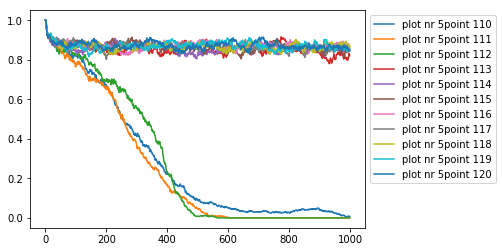

In [97]:
for i in range(605-11,605,1) :
    nr=(i)%121
    a = np.loadtxt("critic_time_series_ws_winnie.txt")[i,:]
    plt.plot(a,label='plot nr %i'%(int(i/121)+1)+"point %i"%nr)
    plt.legend(bbox_to_anchor=(1,1))
#     plt.axhline(y=0.6)
#     plt.axhline(y=0.4)

#     k = 1000
#     phi_star = sum(a[0,k-100:k])/100 #obtaining average phi_star of the last 100 time steps
#     print("phi_star=",phi_star)

In [ ]:
# '''time series plot'''

# for i in range(1087,1088) :
#     nr=(i+1)%121
#     a = np.loadtxt("critic_time_series.txt")[i,:]
#     plt.plot(a,label='plot nr %i'%int(i/121)+"point %i"%nr)
#     plt.legend(bbox_to_anchor=(1,1))
#     plt.xlim([0,15])
# #     plt.axhline(y=0.6)
# #     plt.axhline(y=0.4)

# #     k = 1000
# #     phi_star = sum(a[0,k-100:k])/100 #obtaining average phi_star of the last 100 time steps
# #     print("phi_star=",phi_star)

In [ ]:
'''averaging time series data'''
f = open("critic_phi_star_data_ws_winnie.txt","w+") 
k = 1000
# phi_star = sum(a[counter,k-100:k])/100 #obtaining average phi_star of the last 100 time steps
# print("phi_star=",phi_star)

counter = 0
for p in range(0,11):
    p = p*0.1
    print(p)
    for start in range(0,11):
        start = start*0.1
        for p_rew in range(0,11) :
            p_rew = p_rew*0.1
            a = np.loadtxt("critic_time_series_ws_winnie.txt")[counter,:]
            phi_star = np.average(a[k-100:k])
            f.write("%f\t%f\t%f\t%f\n" % (p,start,p_rew,phi_star))
            f.flush()
            counter = counter + 1
print(counter)

AxesSubplot(0.125,0.71587;0.227941x0.16413)
AxesSubplot(0.398529,0.71587;0.227941x0.16413)
AxesSubplot(0.672059,0.71587;0.227941x0.16413)
AxesSubplot(0.125,0.518913;0.227941x0.16413)
AxesSubplot(0.398529,0.518913;0.227941x0.16413)
AxesSubplot(0.672059,0.518913;0.227941x0.16413)
AxesSubplot(0.125,0.321957;0.227941x0.16413)
AxesSubplot(0.398529,0.321957;0.227941x0.16413)
AxesSubplot(0.672059,0.321957;0.227941x0.16413)
AxesSubplot(0.125,0.125;0.227941x0.16413)
AxesSubplot(0.398529,0.125;0.227941x0.16413)
AxesSubplot(0.672059,0.125;0.227941x0.16413)


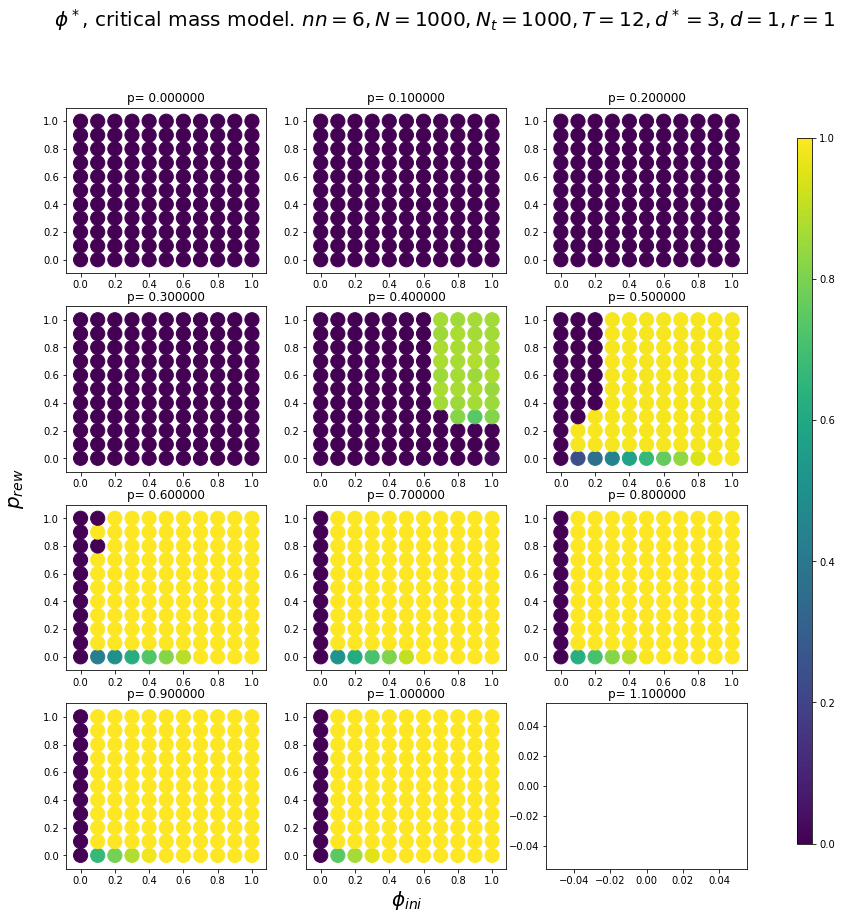

In [53]:
'''colour plot again :P'''
# a = np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,0]
# b =  np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,1]
# c =  np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,2]
d = np.loadtxt("critic_phi_star_data_ws_winnie.txt")[:,3]


counter = 0
l = 0
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(14,14))
i = 0
for row in ax:
    k = 0
    for col in row:
        print(col)
        ax[i, k].set_title('p= %f' %l)
        l = l + 0.1
        j = 121*counter
        im = col.scatter(np.loadtxt("critic_phi_star_data_ws_winnie.txt")[j:121*(counter+1),1],np.loadtxt("critic_phi_star_data_ws_winnie.txt")[j:121*(counter+1),2], c=np.loadtxt("critic_phi_star_data_ws_winnie.txt")[j:121*(counter+1),3],s=200,vmin=0, vmax=1)
        k = k + 1
        counter = counter + 1
    i = i + 1

nax = fig.add_subplot(111, frame_on = False)
nax.set_xticks([])
nax.set_yticks([])
fig.suptitle(r'$\phi^*$, critical mass model. $nn=6,N=1000,N_t=1000,T=12,d^*=3,d=1,r=1$',fontsize = 20)
nax.set_xlabel(r'$\phi_{ini}$', fontsize = 20, labelpad=20)
nax.set_ylabel(r'$p_{rew}$', fontsize = 20, labelpad=40)
fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.savefig("critic_params_winnie.svg", format="svg")

# for i in range(1, 13):
#     plt.subplot(4, 3, i)
#     j = 121*counter
#     print(j)
#     plt.scatter(np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[j:121*(counter+1),1],np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[j:121*(counter+1),2], c=np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[j:121*(counter+1),3],s=200)
# #     plt.colorbar()
#     # plt.title(r'$\phi^*$, Critical Threshold Model. $d^*=3,T=12, N=100,N_t=1000,r=1,rho=1$',fontsize=15,fontweight='bold')
#     # plt.title(r'$\phi^*$, Epidemic Threshold Model. $d^*=1,T=2, N=100,N_t=1000,r=0.5,rho=1$',fontsize=15,fontweight='bold')
#     plt.title('p')
#     plt.xlabel(r'$\phi_{ini}$',fontsize=15)
#     plt.ylabel(r'$\phi_{rew}$',fontsize=15)
#     counter = counter + 1 

In [4]:
a = np.loadtxt("critic_time_series_ws_winnie.txt")[0,:]

df = pd.DataFrame(a,index=range(0,1000))
# a = np.loadtxt("critic_time_series_ws_winnie.txt")[120,:]
# df[2] = pd.DataFrame(a,index=range(0,1000))

for i in range(1,1321) :
    print(i)
    a = np.loadtxt("critic_time_series_ws_winnie.txt")[i,:]
    df[i] = pd.DataFrame(a,index=range(0,1000))
df


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


,0,1,2,3,4,5,6,7,8,9,...,1311,1312,1313,1314,1315,1316,1317,1318,1319,1320
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,0.900,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.903,0.904,0.911,0.922,0.922,0.929,0.946,0.960,0.977,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.907,0.908,0.919,0.942,0.944,0.956,0.968,0.982,0.992,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.910,0.920,0.937,0.953,0.969,0.975,0.988,0.990,0.997,1.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.920,0.931,0.950,0.972,0.982,0.991,0.996,0.996,0.999,1.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.935,0.948,0.961,0.982,0.996,0.997,0.998,0.999,1.000,1.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.947,0.965,0.975,0.987,0.997,0.998,0.999,1.000,1.000,1.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.954,0.980,0.980,0.994,1.000,1.000,1.000,1.000,1.000,1.0


In [13]:
df.to_csv('df_critic_ss_ws_winnie.csv')

In [86]:
df = pd.read_csv('df_critic_ss_ws_winnie.csv')
df.iloc[:, [484+77]]

,560
0,0.600
1,0.600
2,0.600
3,0.578
4,0.563
5,0.554
6,0.552
7,0.539
8,0.537
9,0.543


In [96]:
time_reach_ss(point,lim,tol,window_size)

steady_state_phi_star= 0.0
steady state reached at i =  684


684

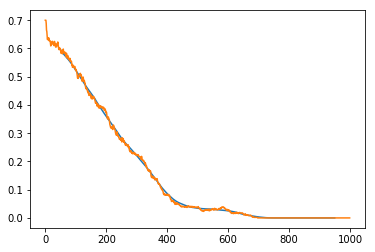

         561
562  0.02935
    561
0  True


In [94]:
point = 484+78

x = df.iloc[:, [point]]
# smooth = x.rolling(window=100,center=False).mean().shift(-199)
smooth = x.rolling(window=100,center=True).mean()
plt.plot(smooth)
a = np.loadtxt("critic_time_series_ws_winnie.txt")[point-1,:]
plt.plot(a)
plt.show()
print(smooth.iloc[[point], [0]])
# print(np.isnan(smooth.iloc[[0], [0]]))
print(pd.isnull(smooth.iloc[[0], [0]]))

In [70]:
def time_reach_ss(point,lim,tol,window_size) :
    x = df.iloc[:, [point]]
    # smooth = x.rolling(window=100,center=False).mean().shift(-199)
    smooth = x.rolling(window=window_size,center=True).mean()
    count = 0
    b = np.loadtxt("critic_phi_star_data_ws_winnie.txt")[point-1,3]
    print('steady_state_phi_star=',b)
    for i in range(0,1000) :
        if not(pd.isnull(smooth.iloc[[i], [0]]).bool()): 
#             print((smooth.iloc[[i], [0]]))
            j = i
            while (((smooth.iloc[[j], [0]]) < (tol+b)) & ((smooth.iloc[[j], [0]]) > (b-tol)) & (j<i+100)).bool() :
                count = count + 1
#                 print('count = ',count)
                j = j + 1
    #             if j == i + 100 : 
            if count >= lim :
                count = 0
                print('steady state reached at i = ',i)
                return i

In [71]:
#opening a file to store data
g = open("critic_ss_ws_winnie.txt","w+") 

point = 1
for p in range(0,11) :
    p = p*0.1
    for start in range(0,11) :
        start = start*0.1
        for p_rew in range(0,11) :
            p_rew = p_rew*0.1
            print('p=',p)
            print('start=',start)
            print('p_rew=',p_rew)
#             for point in range(484+77,484+77+11) :
            print('point=',point)
            tol = 0.005
            lim = 200
            window_size = 50
            i = time_reach_ss(point,lim,tol,window_size)
            if i is not None :
                g.write("%f\t%f\t%f\t%f\n" % (p,start,p_rew,i))
                g.flush()
                point = point + 1
            else :
#                 g.write("%f\t%f\t%f\t\n" % (p,start,p_rew))
                point = point + 1

p= 0.0
start= 0.0
p_rew= 0.0
point= 1
steady_state_phi_star= 0.0
steady state reached at i =  26
p= 0.0
start= 0.0
p_rew= 0.1
point= 2
steady_state_phi_star= 0.0
steady state reached at i =  26
p= 0.0
start= 0.0
p_rew= 0.2
point= 3
steady_state_phi_star= 0.0
steady state reached at i =  26
p= 0.0
start= 0.0
p_rew= 0.30000000000000004
point= 4
steady_state_phi_star= 0.0
steady state reached at i =  26
p= 0.0
start= 0.0
p_rew= 0.4
point= 5
steady_state_phi_star= 0.0
steady state reached at i =  26
p= 0.0
start= 0.0
p_rew= 0.5
point= 6
steady_state_phi_star= 0.0
steady state reached at i =  26
p= 0.0
start= 0.0
p_rew= 0.6000000000000001
point= 7
steady_state_phi_star= 0.0
steady state reached at i =  26
p= 0.0
start= 0.0
p_rew= 0.7000000000000001
point= 8
steady_state_phi_star= 0.0
steady state reached at i =  26
p= 0.0
start= 0.0
p_rew= 0.8
point= 9
steady_state_phi_star= 0.0
steady state reached at i =  26
p= 0.0
start= 0.0
p_rew= 0.9
point= 10
steady_state_phi_star= 0.0
steady state re

steady state reached at i =  34
p= 0.0
start= 0.7000000000000001
p_rew= 0.0
point= 78
steady_state_phi_star= 0.0
steady state reached at i =  34
p= 0.0
start= 0.7000000000000001
p_rew= 0.1
point= 79
steady_state_phi_star= 0.0
steady state reached at i =  34
p= 0.0
start= 0.7000000000000001
p_rew= 0.2
point= 80
steady_state_phi_star= 0.0
steady state reached at i =  34
p= 0.0
start= 0.7000000000000001
p_rew= 0.30000000000000004
point= 81
steady_state_phi_star= 0.0
steady state reached at i =  34
p= 0.0
start= 0.7000000000000001
p_rew= 0.4
point= 82
steady_state_phi_star= 0.0
steady state reached at i =  34
p= 0.0
start= 0.7000000000000001
p_rew= 0.5
point= 83
steady_state_phi_star= 0.0
steady state reached at i =  34
p= 0.0
start= 0.7000000000000001
p_rew= 0.6000000000000001
point= 84
steady_state_phi_star= 0.0
steady state reached at i =  34
p= 0.0
start= 0.7000000000000001
p_rew= 0.7000000000000001
point= 85
steady_state_phi_star= 0.0
steady state reached at i =  34
p= 0.0
start= 0.70

steady state reached at i =  36
p= 0.1
start= 0.30000000000000004
p_rew= 0.1
point= 156
steady_state_phi_star= 0.0
steady state reached at i =  35
p= 0.1
start= 0.30000000000000004
p_rew= 0.2
point= 157
steady_state_phi_star= 0.0
steady state reached at i =  35
p= 0.1
start= 0.30000000000000004
p_rew= 0.30000000000000004
point= 158
steady_state_phi_star= 0.0
steady state reached at i =  35
p= 0.1
start= 0.30000000000000004
p_rew= 0.4
point= 159
steady_state_phi_star= 0.0
steady state reached at i =  35
p= 0.1
start= 0.30000000000000004
p_rew= 0.5
point= 160
steady_state_phi_star= 0.0
steady state reached at i =  34
p= 0.1
start= 0.30000000000000004
p_rew= 0.6000000000000001
point= 161
steady_state_phi_star= 0.0
steady state reached at i =  34
p= 0.1
start= 0.30000000000000004
p_rew= 0.7000000000000001
point= 162
steady_state_phi_star= 0.0
steady state reached at i =  34
p= 0.1
start= 0.30000000000000004
p_rew= 0.8
point= 163
steady_state_phi_star= 0.0
steady state reached at i =  34
p=

steady state reached at i =  38
p= 0.1
start= 0.9
p_rew= 1.0
point= 231
steady_state_phi_star= 0.0
steady state reached at i =  38
p= 0.1
start= 1.0
p_rew= 0.0
point= 232
steady_state_phi_star= 0.0
steady state reached at i =  38
p= 0.1
start= 1.0
p_rew= 0.1
point= 233
steady_state_phi_star= 0.0
steady state reached at i =  38
p= 0.1
start= 1.0
p_rew= 0.2
point= 234
steady_state_phi_star= 0.0
steady state reached at i =  38
p= 0.1
start= 1.0
p_rew= 0.30000000000000004
point= 235
steady_state_phi_star= 0.0
steady state reached at i =  38
p= 0.1
start= 1.0
p_rew= 0.4
point= 236
steady_state_phi_star= 0.0
steady state reached at i =  38
p= 0.1
start= 1.0
p_rew= 0.5
point= 237
steady_state_phi_star= 0.0
steady state reached at i =  38
p= 0.1
start= 1.0
p_rew= 0.6000000000000001
point= 238
steady_state_phi_star= 0.0
steady state reached at i =  38
p= 0.1
start= 1.0
p_rew= 0.7000000000000001
point= 239
steady_state_phi_star= 0.0
steady state reached at i =  38
p= 0.1
start= 1.0
p_rew= 0.8
po

steady state reached at i =  39
p= 0.2
start= 0.6000000000000001
p_rew= 0.0
point= 309
steady_state_phi_star= 0.0
steady state reached at i =  46
p= 0.2
start= 0.6000000000000001
p_rew= 0.1
point= 310
steady_state_phi_star= 0.0
steady state reached at i =  44
p= 0.2
start= 0.6000000000000001
p_rew= 0.2
point= 311
steady_state_phi_star= 0.0
steady state reached at i =  44
p= 0.2
start= 0.6000000000000001
p_rew= 0.30000000000000004
point= 312
steady_state_phi_star= 0.0
steady state reached at i =  43
p= 0.2
start= 0.6000000000000001
p_rew= 0.4
point= 313
steady_state_phi_star= 0.0
steady state reached at i =  42
p= 0.2
start= 0.6000000000000001
p_rew= 0.5
point= 314
steady_state_phi_star= 0.0
steady state reached at i =  43
p= 0.2
start= 0.6000000000000001
p_rew= 0.6000000000000001
point= 315
steady_state_phi_star= 0.0
steady state reached at i =  41
p= 0.2
start= 0.6000000000000001
p_rew= 0.7000000000000001
point= 316
steady_state_phi_star= 0.0
steady state reached at i =  41
p= 0.2
sta

steady_state_phi_star= 0.0
steady state reached at i =  33
p= 0.30000000000000004
start= 0.1
p_rew= 0.8
point= 383
steady_state_phi_star= 0.0
steady state reached at i =  33
p= 0.30000000000000004
start= 0.1
p_rew= 0.9
point= 384
steady_state_phi_star= 0.0
steady state reached at i =  31
p= 0.30000000000000004
start= 0.1
p_rew= 1.0
point= 385
steady_state_phi_star= 0.0
steady state reached at i =  32
p= 0.30000000000000004
start= 0.2
p_rew= 0.0
point= 386
steady_state_phi_star= 0.0
steady state reached at i =  62
p= 0.30000000000000004
start= 0.2
p_rew= 0.1
point= 387
steady_state_phi_star= 0.0
steady state reached at i =  54
p= 0.30000000000000004
start= 0.2
p_rew= 0.2
point= 388
steady_state_phi_star= 0.0
steady state reached at i =  58
p= 0.30000000000000004
start= 0.2
p_rew= 0.30000000000000004
point= 389
steady_state_phi_star= 0.0
steady state reached at i =  50
p= 0.30000000000000004
start= 0.2
p_rew= 0.4
point= 390
steady_state_phi_star= 0.0
steady state reached at i =  43
p= 0.

steady state reached at i =  61
p= 0.30000000000000004
start= 0.7000000000000001
p_rew= 0.7000000000000001
point= 448
steady_state_phi_star= 0.0
steady state reached at i =  57
p= 0.30000000000000004
start= 0.7000000000000001
p_rew= 0.8
point= 449
steady_state_phi_star= 0.0
steady state reached at i =  57
p= 0.30000000000000004
start= 0.7000000000000001
p_rew= 0.9
point= 450
steady_state_phi_star= 0.0
steady state reached at i =  55
p= 0.30000000000000004
start= 0.7000000000000001
p_rew= 1.0
point= 451
steady_state_phi_star= 0.0
steady state reached at i =  58
p= 0.30000000000000004
start= 0.8
p_rew= 0.0
point= 452
steady_state_phi_star= 0.0
steady state reached at i =  82
p= 0.30000000000000004
start= 0.8
p_rew= 0.1
point= 453
steady_state_phi_star= 0.0
steady state reached at i =  70
p= 0.30000000000000004
start= 0.8
p_rew= 0.2
point= 454
steady_state_phi_star= 0.0
steady state reached at i =  70
p= 0.30000000000000004
start= 0.8
p_rew= 0.30000000000000004
point= 455
steady_state_phi

steady state reached at i =  104
p= 0.4
start= 0.30000000000000004
p_rew= 0.30000000000000004
point= 521
steady_state_phi_star= 0.0
steady state reached at i =  107
p= 0.4
start= 0.30000000000000004
p_rew= 0.4
point= 522
steady_state_phi_star= 0.0
steady state reached at i =  92
p= 0.4
start= 0.30000000000000004
p_rew= 0.5
point= 523
steady_state_phi_star= 0.0
steady state reached at i =  65
p= 0.4
start= 0.30000000000000004
p_rew= 0.6000000000000001
point= 524
steady_state_phi_star= 0.0
steady state reached at i =  64
p= 0.4
start= 0.30000000000000004
p_rew= 0.7000000000000001
point= 525
steady_state_phi_star= 0.0
steady state reached at i =  60
p= 0.4
start= 0.30000000000000004
p_rew= 0.8
point= 526
steady_state_phi_star= 0.0
steady state reached at i =  54
p= 0.4
start= 0.30000000000000004
p_rew= 0.9
point= 527
steady_state_phi_star= 0.0
steady state reached at i =  56
p= 0.4
start= 0.30000000000000004
p_rew= 1.0
point= 528
steady_state_phi_star= 0.0
steady state reached at i =  54


steady_state_phi_star= 0.8656
steady state reached at i =  79
p= 0.4
start= 1.0
p_rew= 0.0
point= 595
steady_state_phi_star= 0.02366
steady state reached at i =  756
p= 0.4
start= 1.0
p_rew= 0.1
point= 596
steady_state_phi_star= 0.0
steady state reached at i =  592
p= 0.4
start= 1.0
p_rew= 0.2
point= 597
steady_state_phi_star= 0.0
steady state reached at i =  556
p= 0.4
start= 1.0
p_rew= 0.30000000000000004
point= 598
steady_state_phi_star= 0.8137
steady state reached at i =  946
p= 0.4
start= 1.0
p_rew= 0.4
point= 599
steady_state_phi_star= 0.85211
steady state reached at i =  89
p= 0.4
start= 1.0
p_rew= 0.5
point= 600
steady_state_phi_star= 0.84621
steady state reached at i =  521
p= 0.4
start= 1.0
p_rew= 0.6000000000000001
point= 601
steady_state_phi_star= 0.87526
steady state reached at i =  108
p= 0.4
start= 1.0
p_rew= 0.7000000000000001
point= 602
steady_state_phi_star= 0.85736
steady state reached at i =  496
p= 0.4
start= 1.0
p_rew= 0.8
point= 603
steady_state_phi_star= 0.87314

steady state reached at i =  65
p= 0.5
start= 0.5
p_rew= 1.0
point= 671
steady_state_phi_star= 0.9864
steady state reached at i =  58
p= 0.5
start= 0.6000000000000001
p_rew= 0.0
point= 672
steady_state_phi_star= 0.75782
steady state reached at i =  927
p= 0.5
start= 0.6000000000000001
p_rew= 0.1
point= 673
steady_state_phi_star= 0.98765
steady state reached at i =  344
p= 0.5
start= 0.6000000000000001
p_rew= 0.2
point= 674
steady_state_phi_star= 0.98699
steady state reached at i =  107
p= 0.5
start= 0.6000000000000001
p_rew= 0.30000000000000004
point= 675
steady_state_phi_star= 0.98448
steady state reached at i =  79
p= 0.5
start= 0.6000000000000001
p_rew= 0.4
point= 676
steady_state_phi_star= 0.98619
steady state reached at i =  70
p= 0.5
start= 0.6000000000000001
p_rew= 0.5
point= 677
steady_state_phi_star= 0.98624
steady state reached at i =  58
p= 0.5
start= 0.6000000000000001
p_rew= 0.6000000000000001
point= 678
steady_state_phi_star= 0.987
steady state reached at i =  55
p= 0.5
s

steady state reached at i =  130
p= 0.6000000000000001
start= 0.1
p_rew= 0.5
point= 743
steady_state_phi_star= 0.99845
steady state reached at i =  123
p= 0.6000000000000001
start= 0.1
p_rew= 0.6000000000000001
point= 744
steady_state_phi_star= 0.99877
steady state reached at i =  154
p= 0.6000000000000001
start= 0.1
p_rew= 0.7000000000000001
point= 745
steady_state_phi_star= 0.99824
steady state reached at i =  130
p= 0.6000000000000001
start= 0.1
p_rew= 0.8
point= 746
steady_state_phi_star= 0.0
steady state reached at i =  134
p= 0.6000000000000001
start= 0.1
p_rew= 0.9
point= 747
steady_state_phi_star= 0.9984
steady state reached at i =  202
p= 0.6000000000000001
start= 0.1
p_rew= 1.0
point= 748
steady_state_phi_star= 0.0
steady state reached at i =  76
p= 0.6000000000000001
start= 0.2
p_rew= 0.0
point= 749
steady_state_phi_star= 0.49966
steady state reached at i =  947
p= 0.6000000000000001
start= 0.2
p_rew= 0.1
point= 750
steady_state_phi_star= 0.99853
steady state reached at i = 

steady state reached at i =  76
p= 0.6000000000000001
start= 0.7000000000000001
p_rew= 0.30000000000000004
point= 807
steady_state_phi_star= 0.9985
steady state reached at i =  51
p= 0.6000000000000001
start= 0.7000000000000001
p_rew= 0.4
point= 808
steady_state_phi_star= 0.99817
steady state reached at i =  48
p= 0.6000000000000001
start= 0.7000000000000001
p_rew= 0.5
point= 809
steady_state_phi_star= 0.99874
steady state reached at i =  46
p= 0.6000000000000001
start= 0.7000000000000001
p_rew= 0.6000000000000001
point= 810
steady_state_phi_star= 0.99887
steady state reached at i =  42
p= 0.6000000000000001
start= 0.7000000000000001
p_rew= 0.7000000000000001
point= 811
steady_state_phi_star= 0.99906
steady state reached at i =  40
p= 0.6000000000000001
start= 0.7000000000000001
p_rew= 0.8
point= 812
steady_state_phi_star= 0.99908
steady state reached at i =  38
p= 0.6000000000000001
start= 0.7000000000000001
p_rew= 0.9
point= 813
steady_state_phi_star= 0.99914
steady state reached at 

steady state reached at i =  76
p= 0.7000000000000001
start= 0.2
p_rew= 0.4
point= 874
steady_state_phi_star= 0.99987
steady state reached at i =  68
p= 0.7000000000000001
start= 0.2
p_rew= 0.5
point= 875
steady_state_phi_star= 0.99994
steady state reached at i =  61
p= 0.7000000000000001
start= 0.2
p_rew= 0.6000000000000001
point= 876
steady_state_phi_star= 0.99987
steady state reached at i =  59
p= 0.7000000000000001
start= 0.2
p_rew= 0.7000000000000001
point= 877
steady_state_phi_star= 0.99991
steady state reached at i =  60
p= 0.7000000000000001
start= 0.2
p_rew= 0.8
point= 878
steady_state_phi_star= 0.99985
steady state reached at i =  58
p= 0.7000000000000001
start= 0.2
p_rew= 0.9
point= 879
steady_state_phi_star= 0.99987
steady state reached at i =  58
p= 0.7000000000000001
start= 0.2
p_rew= 1.0
point= 880
steady_state_phi_star= 0.99994
steady state reached at i =  60
p= 0.7000000000000001
start= 0.30000000000000004
p_rew= 0.0
point= 881
steady_state_phi_star= 0.71122
steady sta

steady state reached at i =  429
p= 0.7000000000000001
start= 0.8
p_rew= 0.1
point= 937
steady_state_phi_star= 0.99996
steady state reached at i =  62
p= 0.7000000000000001
start= 0.8
p_rew= 0.2
point= 938
steady_state_phi_star= 0.99987
steady state reached at i =  48
p= 0.7000000000000001
start= 0.8
p_rew= 0.30000000000000004
point= 939
steady_state_phi_star= 0.99991
steady state reached at i =  43
p= 0.7000000000000001
start= 0.8
p_rew= 0.4
point= 940
steady_state_phi_star= 0.99993
steady state reached at i =  40
p= 0.7000000000000001
start= 0.8
p_rew= 0.5
point= 941
steady_state_phi_star= 0.99989
steady state reached at i =  36
p= 0.7000000000000001
start= 0.8
p_rew= 0.6000000000000001
point= 942
steady_state_phi_star= 0.99992
steady state reached at i =  35
p= 0.7000000000000001
start= 0.8
p_rew= 0.7000000000000001
point= 943
steady_state_phi_star= 0.99999
steady state reached at i =  34
p= 0.7000000000000001
start= 0.8
p_rew= 0.8
point= 944
steady_state_phi_star= 0.99994
steady st

steady state reached at i =  44
p= 0.8
start= 0.30000000000000004
p_rew= 0.8
point= 1010
steady_state_phi_star= 1.0
steady state reached at i =  44
p= 0.8
start= 0.30000000000000004
p_rew= 0.9
point= 1011
steady_state_phi_star= 1.0
steady state reached at i =  43
p= 0.8
start= 0.30000000000000004
p_rew= 1.0
point= 1012
steady_state_phi_star= 1.0
steady state reached at i =  43
p= 0.8
start= 0.4
p_rew= 0.0
point= 1013
steady_state_phi_star= 0.88649
p= 0.8
start= 0.4
p_rew= 0.1
point= 1014
steady_state_phi_star= 1.0
steady state reached at i =  84
p= 0.8
start= 0.4
p_rew= 0.2
point= 1015
steady_state_phi_star= 1.0
steady state reached at i =  57
p= 0.8
start= 0.4
p_rew= 0.30000000000000004
point= 1016
steady_state_phi_star= 1.0
steady state reached at i =  51
p= 0.8
start= 0.4
p_rew= 0.4
point= 1017
steady_state_phi_star= 1.0
steady state reached at i =  48
p= 0.8
start= 0.4
p_rew= 0.5
point= 1018
steady_state_phi_star= 1.0
steady state reached at i =  46
p= 0.8
start= 0.4
p_rew= 0.60000

steady state reached at i =  26
p= 0.8
start= 1.0
p_rew= 0.8
point= 1087
steady_state_phi_star= 1.0
steady state reached at i =  26
p= 0.8
start= 1.0
p_rew= 0.9
point= 1088
steady_state_phi_star= 1.0
steady state reached at i =  26
p= 0.8
start= 1.0
p_rew= 1.0
point= 1089
steady_state_phi_star= 1.0
steady state reached at i =  26
p= 0.9
start= 0.0
p_rew= 0.0
point= 1090
steady_state_phi_star= 0.0
steady state reached at i =  26
p= 0.9
start= 0.0
p_rew= 0.1
point= 1091
steady_state_phi_star= 0.0
steady state reached at i =  26
p= 0.9
start= 0.0
p_rew= 0.2
point= 1092
steady_state_phi_star= 0.0
steady state reached at i =  26
p= 0.9
start= 0.0
p_rew= 0.30000000000000004
point= 1093
steady_state_phi_star= 0.0
steady state reached at i =  26
p= 0.9
start= 0.0
p_rew= 0.4
point= 1094
steady_state_phi_star= 0.0
steady state reached at i =  26
p= 0.9
start= 0.0
p_rew= 0.5
point= 1095
steady_state_phi_star= 0.0
steady state reached at i =  26
p= 0.9
start= 0.0
p_rew= 0.6000000000000001
point= 1

steady state reached at i =  35
p= 0.9
start= 0.6000000000000001
p_rew= 0.8
point= 1164
steady_state_phi_star= 1.0
steady state reached at i =  34
p= 0.9
start= 0.6000000000000001
p_rew= 0.9
point= 1165
steady_state_phi_star= 1.0
steady state reached at i =  34
p= 0.9
start= 0.6000000000000001
p_rew= 1.0
point= 1166
steady_state_phi_star= 1.0
steady state reached at i =  32
p= 0.9
start= 0.7000000000000001
p_rew= 0.0
point= 1167
steady_state_phi_star= 1.0
steady state reached at i =  486
p= 0.9
start= 0.7000000000000001
p_rew= 0.1
point= 1168
steady_state_phi_star= 1.0
steady state reached at i =  56
p= 0.9
start= 0.7000000000000001
p_rew= 0.2
point= 1169
steady_state_phi_star= 1.0
steady state reached at i =  45
p= 0.9
start= 0.7000000000000001
p_rew= 0.30000000000000004
point= 1170
steady_state_phi_star= 1.0
steady state reached at i =  39
p= 0.9
start= 0.7000000000000001
p_rew= 0.4
point= 1171
steady_state_phi_star= 1.0
steady state reached at i =  36
p= 0.9
start= 0.700000000000000

steady_state_phi_star= 1.0
steady state reached at i =  43
p= 1.0
start= 0.2
p_rew= 1.0
point= 1243
steady_state_phi_star= 1.0
steady state reached at i =  43
p= 1.0
start= 0.30000000000000004
p_rew= 0.0
point= 1244
steady_state_phi_star= 0.94936
p= 1.0
start= 0.30000000000000004
p_rew= 0.1
point= 1245
steady_state_phi_star= 1.0
steady state reached at i =  67
p= 1.0
start= 0.30000000000000004
p_rew= 0.2
point= 1246
steady_state_phi_star= 1.0
steady state reached at i =  55
p= 1.0
start= 0.30000000000000004
p_rew= 0.30000000000000004
point= 1247
steady_state_phi_star= 1.0
steady state reached at i =  47
p= 1.0
start= 0.30000000000000004
p_rew= 0.4
point= 1248
steady_state_phi_star= 1.0
steady state reached at i =  47
p= 1.0
start= 0.30000000000000004
p_rew= 0.5
point= 1249
steady_state_phi_star= 1.0
steady state reached at i =  43
p= 1.0
start= 0.30000000000000004
p_rew= 0.6000000000000001
point= 1250
steady_state_phi_star= 1.0
steady state reached at i =  41
p= 1.0
start= 0.3000000000

steady state reached at i =  29
p= 1.0
start= 0.9
p_rew= 0.8
point= 1318
steady_state_phi_star= 1.0
steady state reached at i =  28
p= 1.0
start= 0.9
p_rew= 0.9
point= 1319
steady_state_phi_star= 1.0
steady state reached at i =  28
p= 1.0
start= 0.9
p_rew= 1.0
point= 1320
steady_state_phi_star= 1.0
steady state reached at i =  27
p= 1.0
start= 1.0
p_rew= 0.0
point= 1321
steady_state_phi_star= 1.0
steady state reached at i =  26
p= 1.0
start= 1.0
p_rew= 0.1
point= 1322


IndexError: positional indexers are out-of-bounds

In [ ]:
'''trying to merge steady state calculation across all points in one cell block
Was becoming tricky
Instead chose to define steady state calculation as a function as above'''

# count = 0
# tol = 0.05
# lim = 100
# b = np.loadtxt("critic_phi_star_data_ws_winnie.txt")[point,3]
# print('steady_state_phi_star=',b)
# count = 100
# i = 0
# if i < 1000 :
#     i = 0
#     while count >=lim :
#         count = 0
#         print('i=',i)
#         if not(pd.isnull(smooth.iloc[[i], [0]]).bool()) : 
#             print((smooth.iloc[[i], [0]]))
#             j = i
#             print(tol+b)
#             while (((smooth.iloc[[j], [0]]) < (tol+b)) & (j<i+100)).bool() :
#                 count = count + 1
#                 print('count = ',count)
#                 j = j + 1
#     #             if j == i + 100 :
#             if count >= lim :
#                 count = 0
#                 print('steady state reached at i = ',i)
#                 break
#             count = 100
#             i = i + 1
#         else :
#             count = 100
#             i = i + 1

1.0
1311
AxesSubplot(0.125,0.71587;0.227941x0.16413)
0 0
0.0
AxesSubplot(0.398529,0.71587;0.227941x0.16413)
121 0.1
0.1
AxesSubplot(0.672059,0.71587;0.227941x0.16413)
242 0.2
0.2
AxesSubplot(0.125,0.518913;0.227941x0.16413)
363 0.3
0.3
AxesSubplot(0.398529,0.518913;0.227941x0.16413)
484 0.4
0.4
AxesSubplot(0.672059,0.518913;0.227941x0.16413)
605 0.5
0.5
AxesSubplot(0.125,0.321957;0.227941x0.16413)
726 0.6
0.6
AxesSubplot(0.398529,0.321957;0.227941x0.16413)
847 0.7
0.7
AxesSubplot(0.672059,0.321957;0.227941x0.16413)
967 0.8
0.8
AxesSubplot(0.125,0.125;0.227941x0.16413)
1086 0.9
0.9
AxesSubplot(0.398529,0.125;0.227941x0.16413)
1203 1.0
1.0
AxesSubplot(0.672059,0.125;0.227941x0.16413)
1310 1.1
1.0


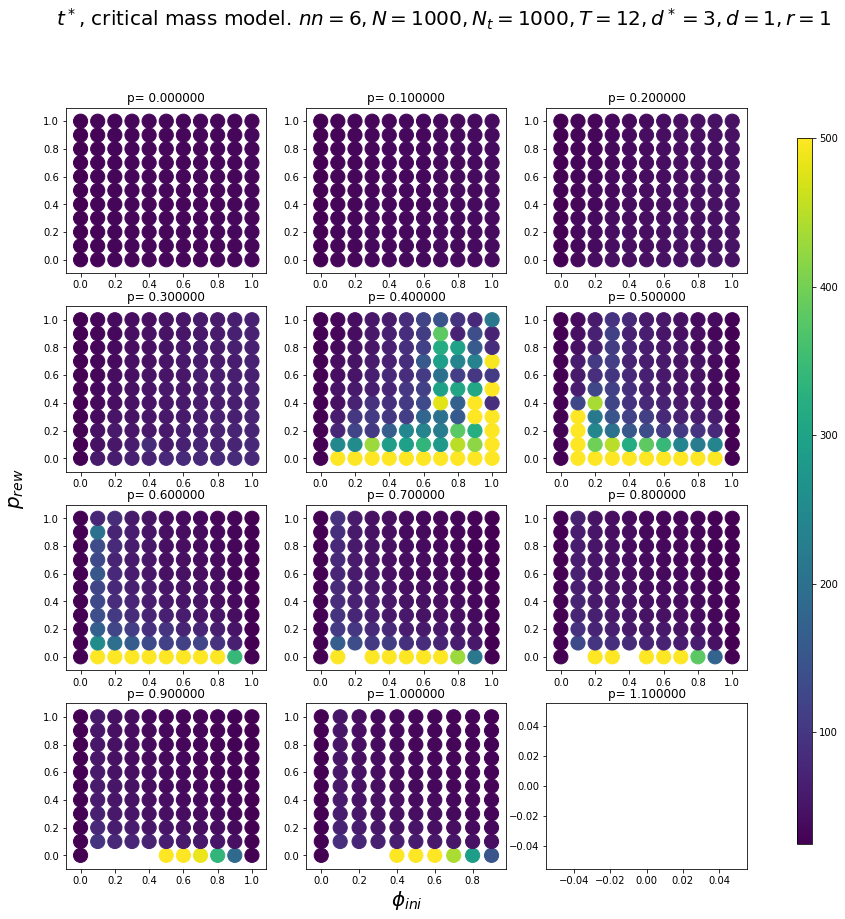

In [92]:
'''colour plot again :P'''
# a = np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,0]
# b =  np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,1]
# c =  np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,2]
d = np.loadtxt("critic_ss_ws_winnie.txt")[:,3]
print(np.loadtxt("critic_ss_ws_winnie.txt")[1238,0])
print(len(d))
count = 0
plot_count = 1
j = 0
l = 0
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(14,14))
i = 0
for row in ax:
    k = 0
    for col in row:
        print(col)
        ax[i, k].set_title('p= %f' %l)
#         count = count + plot_count-1
        plot_count = 0
        print(count,round(l,2))
        print(np.loadtxt("critic_ss_ws_winnie.txt")[count,0])
        while (count < len(d)-1) and np.loadtxt("critic_ss_ws_winnie.txt")[count,0] == round(l,2)  :
            plot_count = plot_count + 1
            count = count + 1
#             print(count)
        end =  count
#         count = plot_count-1
        im = col.scatter(np.loadtxt("critic_ss_ws_winnie.txt")[j:end,1],np.loadtxt("critic_ss_ws_winnie.txt")[j:end,2], c=np.loadtxt("critic_ss_ws_winnie.txt")[j:end,3],s=200,vmin=25, vmax=500)
        j = end
        l = l + 0.1
        k = k + 1
    i = i + 1

nax = fig.add_subplot(111, frame_on = False)
nax.set_xticks([])
nax.set_yticks([])
fig.suptitle(r'$t^*$, critical mass model. $nn=6,N=1000,N_t=1000,T=12,d^*=3,d=1,r=1$',fontsize = 20)
nax.set_xlabel(r'$\phi_{ini}$', fontsize = 20, labelpad=20)
nax.set_ylabel(r'$p_{rew}$', fontsize = 20, labelpad=40)
fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.savefig("critic_steady_state.svg", format="svg")

In [ ]:
c = np.asarray([(0, 0, 1, a) for a in alpha])
scatter(x, y, color=c, edgecolors=c)